In [1]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import ot

## Load data
Change id to correspond to the id used in experiments.ipynb

In [17]:
#BCNN and SNPE-C results
bcnn_id = 'test_02'
sbi_id = 'test_01'

bcnn_post = np.load(f'{bcnn_id}/bcnn_{bcnn_id}_post.npy') #num_bins= 4^2
bcnn_post = bcnn_post.astype('float64')
bcnn_time = np.load(f'{bcnn_id}/bcnn_{bcnn_id}_time.npy')
sbi_post = np.load(f'{sbi_id}/sbi_{sbi_id}_post.npy')
sbi_post = sbi_post.astype('float64')
sbi_time = np.load(f'{sbi_id}/sbi_{sbi_id}_time.npy')

#ABC-SMC
smcabc_post = np.load('smcabc_posteriors_batchsize1_samples3k.npy', allow_pickle=True)
smcabc_counts = np.load('smcabc_trails_batchsize1_samples3k.npy', allow_pickle=True)

#get true posterior from mcmc run
subset_exact_samples = np.load('exact_mcmc_post.npy')

## Compute mean and std

In [552]:
sbi_post_mean = sbi_post.mean(axis=2)
sbi_post_std = sbi_post.std(axis=2)

sbi_time_mean = sbi_time.mean(axis=0)
sbi_time_std = sbi_time.std(axis=0)

bcnn_post_mean = bcnn_post.mean(axis=2)
bcnn_post_std = bcnn_post.std(axis=2)

bcnn_time_mean = bcnn_time.mean(axis=0)
bcnn_time_std = bcnn_time.std(axis=0)

## Compute EMD and MMD
Obs these take a while to compute

In [24]:
def get_EMD(est_post, true_post):
    emds = []   
    for run in est_post:
        run_emd = []
        for gen in run:
            n = len(gen)
            a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples
            subset_idx = np.random.randint(0, len(true_post), size=n)
            subset_exact_samples = true_post[subset_idx]
            # loss matrix
            M = ot.dist(gen, subset_exact_samples)
            G0 = ot.emd(a, b, M, log=True, numItermax=100000)
            run_emd.append(G0[1].get('cost'))
        emds.append(run_emd)
    
    return np.asarray(emds)

def get_MMD(est_post, true_post):
    emds = []   
    for run in est_post:
        run_emd = []
        for gen in run:
            mmd = np.linalg.norm(true_post.mean(axis=0) - np.array(gen).mean(axis=0))
            
            run_emd.append(mmd)
        emds.append(run_emd)
    
    return np.asarray(emds)

In [ ]:
bcnn_emd = get_EMD(bcnn_post, exact_samples)
bcnn_mmd = get_MMD(bcnn_post, exact_samples)

sbi_emd = get_EMD(sbi_post, exact_samples)
sbi_mmd = get_MMD(sbi_post, exact_samples)

smc_emd = get_EMD(smcabc_post, exact_samples)
smc_mmd = get_MMD(smcabc_post, exact_samples)

### Plotting mean and std of p(theta| y_obs) 
Never used in manuscript, plots marginal mean and std over different seeds

/home/psingh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


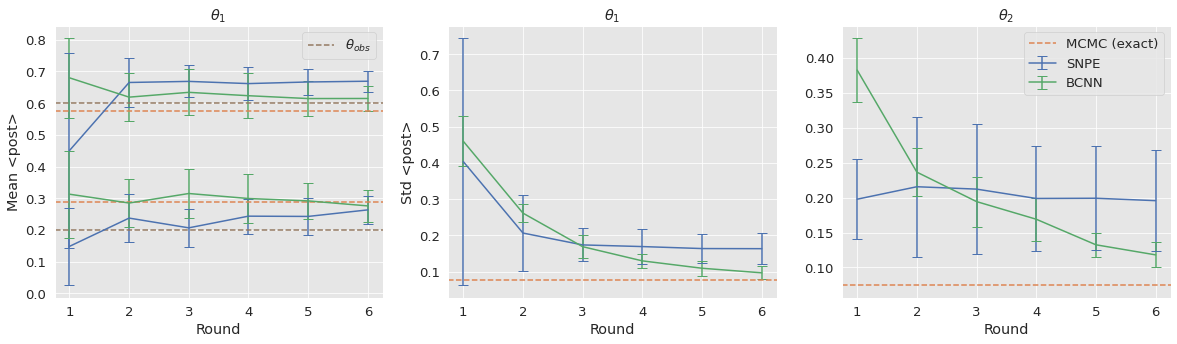

In [40]:
sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})


f = plt.figure(figsize=(20, 5))
gs = f.add_gridspec(1, 3)

#Theta 1 E(<post>)
ax = f.add_subplot(gs[0, 0])
ax.errorbar(x=np.arange(6)+1, y=sbi_post_mean.mean(axis=0)[:,0], 
            yerr=sbi_post_mean.std(axis=0)[:,0], 
            capsize=5, color='C0')
ax.errorbar(x=np.arange(6)+1, y=bcnn_post_mean.mean(axis=0)[1:,0], 
            yerr=bcnn_post_mean.std(axis=0)[1:,0],
            capsize=5, color='C2')
ax.axhline(0.6, linestyle='--', color='C5', label=r'$\theta_{obs}$')
ax.axhline(subset_exact_samples.mean(axis=0)[0], linestyle='--', color='C1')
ax.set_ylabel('Mean <post>')
ax.set_xlabel('Round')
ax.set_title(r'$\theta_1$')
plt.legend()

#Theta 2 E(<post>)
ax = f.add_subplot(gs[0, 0])
ax.errorbar(x=np.arange(6)+1, y=sbi_post_mean.mean(axis=0)[:,1], 
            yerr=sbi_post_mean.std(axis=0)[:,1], 
            capsize=5, color='C0')
ax.errorbar(x=np.arange(6)+1, y=bcnn_post_mean.mean(axis=0)[1:,1], 
            yerr=bcnn_post_mean.std(axis=0)[1:,1], 
            capsize=5, color='C2')
ax.axhline(0.2, linestyle='--', color='C5')
ax.axhline(subset_exact_samples.mean(axis=0)[1], linestyle='--', color='C1')
ax.set_xlabel('Round')


#Theta 1 std(<post>)
ax = f.add_subplot(gs[0, 1])
ax.errorbar(x=np.arange(6)+1, y=sbi_post_std.mean(axis=0)[:,0], 
            yerr=sbi_post_std.std(axis=0)[:,0], 
            capsize=5, color='C0')
ax.errorbar(x=np.arange(6)+1, y=bcnn_post_std.mean(axis=0)[1:,0], 
            yerr=bcnn_post_std.std(axis=0)[1:,0],
            capsize=5, color='C2')
ax.axhline(subset_exact_samples.std(axis=0)[0], linestyle='--', color='C1')
ax.set_ylabel('Std <post>')
ax.set_xlabel('Round')
ax.set_title(r'$\theta_1$')


#Theta 2 std(<post>)
ax = f.add_subplot(gs[0, 2])
ax.errorbar(x=np.arange(6)+1, y=sbi_post_std.mean(axis=0)[:,1], 
            yerr=sbi_post_std.std(axis=0)[:,1], 
            capsize=5, color='C0', label='SNPE')
ax.errorbar(x=np.arange(6)+1, y=bcnn_post_std.mean(axis=0)[1:,1], 
            yerr=bcnn_post_std.std(axis=0)[1:,1], 
            capsize=5, color='C2', label='BCNN')
ax.axhline(subset_exact_samples.std(axis=0)[1], linestyle='--', color='C1', label='MCMC (exact)')
ax.set_xlabel('Round')
ax.set_title(r'$\theta_2$')

plt.legend()

### Plotting execution time
Obs. these execution times should not be considered a complete evaluation of the computations time between methods. Presented in Supplementary Materials

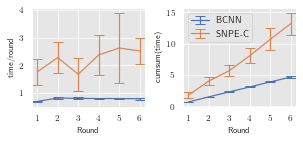

In [15]:
sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

sns.set_theme()
font_size = 8
sns.set_context("paper", rc={"font.size":font_size,"axes.titlesize":font_size,"axes.labelsize":font_size, "axis.legendsize":font_size })
sns.set_style("darkgrid", {"axes.facecolor": ".9"})


f = plt.figure(figsize=(4.25, 2))
gs = f.add_gridspec(1, 2)


ax = f.add_subplot(gs[0, 0])

ax.errorbar(x=np.arange(6)+1, y=bcnn_time.mean(axis=0)/60, 
            yerr=bcnn_time.std(axis=0)/60, 
            capsize=5, color='C0', label='BCNN')
ax.errorbar(x=np.arange(6)+1, y=sbi_time.mean(axis=0)/60, 
            yerr=sbi_time.std(axis=0)/60, 
            capsize=5, color='C1', label='SNPE')
ax.set_xlabel("Round")
ax.set_ylabel("time/round")

ax.set_xticks([1,2,3,4,5,6])

ax = f.add_subplot(gs[0, 1])

bcnn_cumsum = np.cumsum(bcnn_time, axis=1)
sbi_cumsum = np.cumsum(sbi_time, axis=1)
ax.errorbar(x=np.arange(6)+1, y=bcnn_cumsum.mean(axis=0)/60, 
            yerr=bcnn_cumsum.std(axis=0)/60, 
            capsize=5, color='C0', label='BCNN')
ax.errorbar(x=np.arange(6)+1, y=sbi_cumsum.mean(axis=0)/60, 
            yerr=sbi_cumsum.std(axis=0)/60, 
            capsize=5, color='C1', label='SNPE-C')

ax.set_xlabel("Round")
ax.set_ylabel("cumsum(time)")
ax.set_xticks([1,2,3,4,5,6])

plt.legend()
plt.tight_layout()

In [16]:
f.savefig('ma2_suppl_time__4.25x2_fontscale08.pdf', dpi=350, bbox_inches = 'tight',
    pad_inches = 0)

### Plotting final p(theta|y_obs) from one particular run

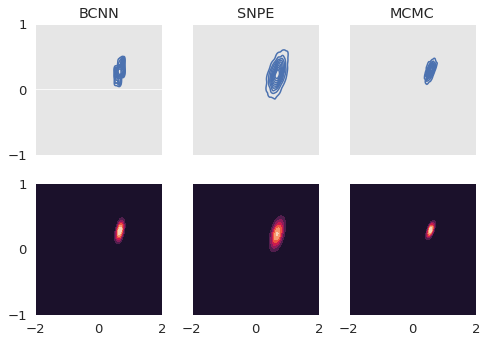

In [50]:
sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

f = plt.figure(figsize=(7, 5))
gs = f.add_gridspec(2, 3)
run_idx = 2

ax = f.add_subplot(gs[0, 0])
sns.kdeplot(x=bcnn_post[run_idx, -1, :, 0], y=bcnn_post[run_idx, -1, :, 1], ax=ax)
ax.set_ylim(-1,1)
ax.set_xlim(-2,2)
ax.set_xticks([])
ax.set_title('BCNN')
ax.set_yticks([-1,0,1])

ax = f.add_subplot(gs[0, 1])
sns.kdeplot(x=sbi_post[run_idx, -1, :, 0], y=sbi_post[run_idx, -1, :, 1], ax=ax)
ax.set_ylim(-1,1)
ax.set_xlim(-2,2)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('SNPE')

ax = f.add_subplot(gs[0, 2])
sns.kdeplot(x=subset_exact_samples[:, 0], y=subset_exact_samples[:, 1], ax=ax)
ax.set_ylim(-1,1)
ax.set_xlim(-2,2)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('MCMC')


#Gaussian approx
cov = np.cov(bcnn_post[run_idx, -1,:,:], rowvar=0)
mean = bcnn_post[run_idx, -1,:,:].mean(axis=0)

x, y = np.mgrid[-2:2:.01, -1:1:.01]
pos = np.dstack((x, y))

rv = scipy.stats.multivariate_normal(mean, cov)


ax = f.add_subplot(gs[1, 0])
ax.contourf(x, y, rv.pdf(pos))
#ax2.scatter(target_theta[:,0],target_theta[:,1], color="red", label="true")
ax.set_xlim(-2,2)
ax.set_ylim(-1,1)
ax.set_yticks([-1,0,1])

cov = np.cov(sbi_post[run_idx, -1,:,:], rowvar=0)
mean = sbi_post[run_idx, -1,:,:].mean(axis=0)

x, y = np.mgrid[-2:2:.01, -1:1:.01]
pos = np.dstack((x, y))

rv = scipy.stats.multivariate_normal(mean, cov)


ax = f.add_subplot(gs[1, 1])
ax.contourf(x, y, rv.pdf(pos))
#ax2.scatter(target_theta[:,0],target_theta[:,1], color="red", label="true")
ax.set_xlim(-2,2)
ax.set_ylim(-1,1)
ax.set_yticks([])

cov = np.cov(subset_exact_samples, rowvar=0)
mean = subset_exact_samples.mean(axis=0)

x, y = np.mgrid[-2:2:.01, -1:1:.01]
pos = np.dstack((x, y))

rv = scipy.stats.multivariate_normal(mean, cov)


ax = f.add_subplot(gs[1, 2])
ax.contourf(x, y, rv.pdf(pos))
#ax2.scatter(target_theta[:,0],target_theta[:,1], color="red", label="true")
ax.set_xlim(-2,2)
ax.set_ylim(-1,1)
ax.set_yticks([])

plt.tight_layout()

## Figure 2 in manuscript (qualitative evaluation)

In [597]:
import matplotlib

matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

sns.set_theme()
font_size = 8
sns.set_context("paper", rc={"font.size":font_size,"axes.titlesize":font_size,"axes.labelsize":font_size, "axis.legendsize":font_size })
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

def plot_grid_alone(run_idx=[2,4]):
    f = plt.figure(figsize=(4.25, 4.25), constrained_layout=True)
    widths = [1, 1, 1, 1, 1]
    heights = [1, 1, 1, 1, 1]
    gs = f.add_gridspec(5, 5, width_ratios=widths, height_ratios=heights)
    #gs = f.add_gridspec(4, 6)
    #BCNN KDE

    def multivar(grid, x, y, xlabel='', ylabel=''):
        ax = f.add_subplot(grid)
        sns.kdeplot(x=x, y=y, ax=ax)
        ax.set_ylim(-1,1)
        ax.set_xlim(-2,2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return ax

    #SMC ABC
    smc = np.array(smcabc_post[run_idx[0],1])
    ax = multivar(gs[4,1], x=smc[:, 0], y=smc[:, 1], xlabel='Round 2')
    ax.text(0.0, 0.0, 'N='+str(smcabc_counts[run_idx[0],1]), transform=ax.transAxes, 
            size=8, weight='bold')
    
    ax.set_ylabel('ABC-SMC')
    smc = np.array(smcabc_post[run_idx[0],3])
    ax = multivar(gs[4,2], x=smc[:, 0], y=smc[:, 1], xlabel='Round 4')
    ax.text(0.0, 0.0, 'N='+str(smcabc_counts[run_idx[0],3]), transform=ax.transAxes, 
            size=8, weight='bold')
    smc = np.array(smcabc_post[run_idx[0], 5])
    ax = multivar(gs[4,3], x=smc[:, 0], y=smc[:, 1],xlabel='Round 6')
    ax.text(0.0, 0.0, 'N='+str(smcabc_counts[run_idx[0],5]), transform=ax.transAxes, 
            size=8, weight='bold')
    cov = np.cov(smc, rowvar=0)
    mean = smc.mean(axis=0)

    x, y = np.mgrid[-2:2:.01, -1:1:.01]
    pos = np.dstack((x, y))

    rv = scipy.stats.multivariate_normal(mean, cov)


    ax = f.add_subplot(gs[4, 4])
    ax.contourf(x, y, rv.pdf(pos))
    #ax2.scatter(target_theta[:,0],target_theta[:,1], color="red", label="true")
    ax.set_xlim(-2,2)
    ax.set_ylim(-1,1)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('Gaussian fit')

  

    #BCNN
    ax = multivar(gs[0,1],x=bcnn_post[run_idx[0], 1+1, :, 0], y=bcnn_post[run_idx[0], 1+1, :, 1], ylabel='BCNN(1)')
    ax = multivar(gs[0,2],x=bcnn_post[run_idx[0], 3+1, :, 0], y=bcnn_post[run_idx[0], 3+1, :, 1])
    ax = multivar(gs[0,3],x=bcnn_post[run_idx[0], 5+1, :, 0], y=bcnn_post[run_idx[0], 5+1, :, 1])
    
    ax = multivar(gs[1,1],x=bcnn_post[run_idx[1], 1+1, :, 0], y=bcnn_post[run_idx[1], 1+1, :, 1], ylabel='BCNN(2)')
    ax = multivar(gs[1,2],x=bcnn_post[run_idx[1], 3+1, :, 0], y=bcnn_post[run_idx[1], 3+1, :, 1])
    ax = multivar(gs[1,3],x=bcnn_post[run_idx[1], 5+1, :, 0], y=bcnn_post[run_idx[1], 5+1, :, 1])

    #SNPE
    ax = multivar(gs[2, 1],x=sbi_post[run_idx[0], 1, :, 0], y=sbi_post[run_idx[0], 1, :, 1], ylabel='SNPE-C(1)')
    ax = multivar(gs[2, 2],x=sbi_post[run_idx[0], 3, :, 0], y=sbi_post[run_idx[0], 3, :, 1])
    ax = multivar(gs[2, 3],x=sbi_post[run_idx[0], 5, :, 0], y=sbi_post[run_idx[0], 5, :, 1])
    
    ax = multivar(gs[3, 1],x=sbi_post[run_idx[1], 1, :, 0], y=sbi_post[run_idx[1], 1, :, 1], ylabel='SNPE-C(2)')
    ax = multivar(gs[3, 2],x=sbi_post[run_idx[1], 3, :, 0], y=sbi_post[run_idx[1], 3, :, 1])
    ax = multivar(gs[3, 3],x=sbi_post[run_idx[1], 5, :, 0], y=sbi_post[run_idx[1], 5, :, 1])


    #BCNN Gaussian approx
    cov = np.cov(bcnn_post[run_idx[0], -1,:,:], rowvar=0)
    mean = bcnn_post[run_idx[0], -1,:,:].mean(axis=0)

    x, y = np.mgrid[-2:2:.01, -1:1:.01]
    pos = np.dstack((x, y))

    rv = scipy.stats.multivariate_normal(mean, cov)


    ax = f.add_subplot(gs[0, 4])
    ax.contourf(x, y, rv.pdf(pos))
    #ax2.scatter(target_theta[:,0],target_theta[:,1], color="red", label="true")
    ax.set_xlim(-2,2)
    ax.set_ylim(-1,1)
    ax.set_yticks([])
    ax.set_xticks([])
    
    cov = np.cov(bcnn_post[run_idx[1], -1,:,:], rowvar=0)
    mean = bcnn_post[run_idx[1], -1,:,:].mean(axis=0)

    x, y = np.mgrid[-2:2:.01, -1:1:.01]
    pos = np.dstack((x, y))

    rv = scipy.stats.multivariate_normal(mean, cov)


    ax = f.add_subplot(gs[1, 4])
    ax.contourf(x, y, rv.pdf(pos))
    #ax2.scatter(target_theta[:,0],target_theta[:,1], color="red", label="true")
    ax.set_xlim(-2,2)
    ax.set_ylim(-1,1)
    ax.set_yticks([])
    ax.set_xticks([])

    #SNPE Gaussian approx
    cov = np.cov(sbi_post[run_idx[0], -1,:,:], rowvar=0)
    mean = sbi_post[run_idx[0], -1,:,:].mean(axis=0)

    x, y = np.mgrid[-2:2:.01, -1:1:.01]
    pos = np.dstack((x, y))

    rv = scipy.stats.multivariate_normal(mean, cov)


    ax = f.add_subplot(gs[2, 4])
    ax.contourf(x, y, rv.pdf(pos))
    
    ax.set_xlim(-2,2)
    ax.set_ylim(-1,1)
    ax.set_yticks([])
    ax.set_xticks([])
    
    
    
    cov = np.cov(sbi_post[run_idx[1], -1,:,:], rowvar=0)
    mean = sbi_post[run_idx[1], -1,:,:].mean(axis=0)

    x, y = np.mgrid[-2:2:.01, -1:1:.01]
    pos = np.dstack((x, y))

    rv = scipy.stats.multivariate_normal(mean, cov)


    ax = f.add_subplot(gs[3, 4])
    ax.contourf(x, y, rv.pdf(pos))
    ax.set_xlim(-2,2)
    ax.set_ylim(-1,1)
    ax.set_yticks([])
    ax.set_xticks([])


    #MCMC Gaussian approx
    cov = np.cov(subset_exact_samples, rowvar=0)
    mean = subset_exact_samples.mean(axis=0)

    x, y = np.mgrid[-2:2:.01, -1:1:.01]
    pos = np.dstack((x, y))

    rv = scipy.stats.multivariate_normal(mean, cov)


    ax = f.add_subplot(gs[0, 0])
    ax.contourf(x, y, rv.pdf(pos))
    ax.set_xlim(-2,2)
    ax.set_ylim(-1,1)
    ax.set_yticks([])
    ax.set_xticks([])

    ax.set_ylabel('MCMC (true)')
    
    return gs, f

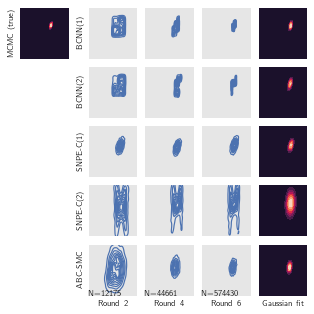

In [598]:
gs, f = plot_grid_alone(run_idx=[2,3])

In [599]:
f.savefig('ma2_grid_4_25x4_25_fontsize8.pdf', dpi=350, bbox_inches = 'tight',
    pad_inches = 0)

## Figure 2 in manuscript: Plot EMD and MMD

In [35]:
import matplotlib.font_manager as fm
import matplotlib
# Rebuild the matplotlib font cache

matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

sns.set_theme()
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8, "axis.legendsize":8 }) 
sns.set_style("darkgrid", {"axes.facecolor": ".9"})



def plot_emd():
    f = plt.figure(figsize=(4.25, 2))
    gs = f.add_gridspec(1, 2)
    
    ax = f.add_subplot(gs[0,0])
    ax.errorbar(x=np.arange(6)+1, y=bcnn_emd.mean(axis=0)[1:], 
            yerr=bcnn_emd.std(axis=0)[1:], 
            capsize=5, color='C2', label="BCNN")

    ax.errorbar(x=np.arange(6)+1, y=sbi_emd.mean(axis=0), 
            yerr=sbi_emd.std(axis=0), 
            capsize=5, color='C0', label="SNPE-C(nfs)")
    
    ax.errorbar(x=np.arange(6)+1, y=smc_emd.mean(axis=0), 
            yerr=smc_emd.std(axis=0), 
            capsize=5, color='C1', label="ABC-SMC")
    plt.ylabel('log Mean EMD')
    #plt.yscale("log")
    #plt.ylim(0, 10)
    plt.yticks([0.0,0.5,1.0,1.5,2.0])
    
    plt.xlabel('Round')
    #f.axes[0].text(-0.1, 1.1, 'B', transform=f.axes[0].transAxes, 
    #        size=20, weight='bold')
    plt.tick_params(labelsize=8)
    plt.legend(fontsize=8)
    plt.xticks([1,2,3,4,5,6])
    
    
    ax = f.add_subplot(gs[0,1])
    ax.errorbar(x=np.arange(6)+1, y=bcnn_mmd.mean(axis=0)[1:], 
            yerr=bcnn_mmd.std(axis=0)[1:], 
            capsize=5, color='C2', label="BCNN")

    ax.errorbar(x=np.arange(6)+1, y=sbi_mmd.mean(axis=0), 
            yerr=sbi_mmd.std(axis=0), 
            capsize=5, color='C0', label="SNPE-C")
    
    ax.errorbar(x=np.arange(6)+1, y=smc_mmd.mean(axis=0), 
            yerr=smc_mmd.std(axis=0), 
            capsize=5, color='C1', label="ABC-SMC")
    plt.ylabel('Mean MMD')
    #plt.yscale("log")
    #plt.ylim(0, 10)
    plt.yticks([0.0,0.2,0.4,0.6,0.8])
    plt.xticks([1,2,3,4,5,6])
    plt.xlabel('Round')
    
    
    plt.tight_layout()
    return f
    

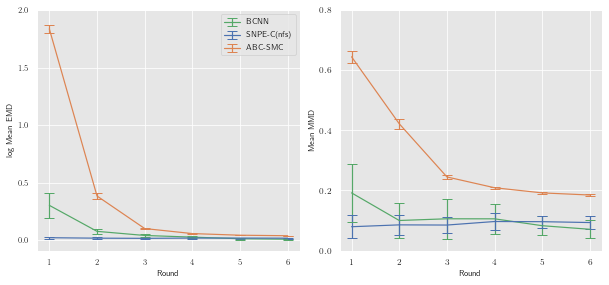

In [34]:
f = plot_emd()

In [596]:
f.savefig('ma2_emd_mmd_4.25x2_fontscale08.pdf', dpi=350, bbox_inches = 'tight',
    pad_inches = 0)

## Supplemental figures

### Grid with more seeds

In [18]:
import matplotlib

matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

sns.set_theme()
font_size = 8
sns.set_context("paper", rc={"font.size":font_size,"axes.titlesize":font_size,"axes.labelsize":font_size, "axis.legendsize":font_size })
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

def plot_grid_suppl(method='bcnn'):
    run_idx = np.arange(sbi_post.shape[0])
    if method == 'bcnn':
        data = bcnn_post[:, 1:, :,:]
    elif method=='snpe':
        data = sbi_post
    
    f = plt.figure(figsize=(4.25, 4.25*1.6), constrained_layout=True)
    #widths = [1, 1, 1, 1, 1]
    #heights = [1, 1, 1, 1, 1]
    gs = f.add_gridspec(11, 7)#, width_ratios=widths, height_ratios=heights)
    #gs = f.add_gridspec(4, 6)
    
    #MCMC Gaussian approx
    cov = np.cov(subset_exact_samples, rowvar=0)
    mean = subset_exact_samples.mean(axis=0)

    x, y = np.mgrid[-2:2:.01, -1:1:.01]
    pos = np.dstack((x, y))

    rv = scipy.stats.multivariate_normal(mean, cov)


    ax = f.add_subplot(gs[0, 0])
    ax.contourf(x, y, rv.pdf(pos))
    #ax2.scatter(target_theta[:,0],target_theta[:,1], color="red", label="true")
    ax.set_xlim(-2,2)
    ax.set_ylim(-1,1)
    ax.set_yticks([])
    ax.set_xticks([])
    #ax.set_xlabel('Gaussian fit')
    ax.set_ylabel('MCMC (true)')
    #ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
    #        size=20, weight='bold')

    def multivar(grid, x, y, xlabel='', ylabel=''):
        ax = f.add_subplot(grid)
        sns.kdeplot(x=x, y=y, ax=ax)
        ax.set_ylim(-1,1)
        ax.set_xlim(-2,2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return ax
    
    for idx in run_idx:
        #data
        for i in range(data.shape[1]):
            ax = multivar(gs[idx+1,i],x=data[idx, i, :, 0], y=data[idx, i, :, 1])
            if idx == run_idx[-1]:
                ax.set_xlabel(f"Round {i+1}")
    
        #Gaussian approx
        cov = np.cov(data[idx, -1,:,:], rowvar=0)
        mean = data[idx, -1,:,:].mean(axis=0)

        x, y = np.mgrid[-2:2:.01, -1:1:.01]
        pos = np.dstack((x, y))

        rv = scipy.stats.multivariate_normal(mean, cov)


        ax = f.add_subplot(gs[idx+1, gs.ncols - 1])
        ax.contourf(x, y, rv.pdf(pos))
        #ax2.scatter(target_theta[:,0],target_theta[:,1], color="red", label="true")
        ax.set_xlim(-2,2)
        ax.set_ylim(-1,1)
        ax.set_yticks([])
        ax.set_xticks([])
        
        if idx == run_idx[-1]:
                ax.set_xlabel(f"Gaussian fit")
        
    
    return gs, f

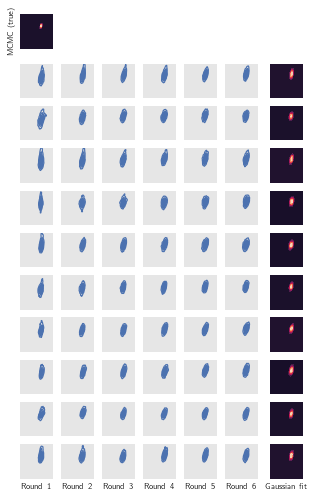

In [21]:
gs,f = plot_grid_suppl('snpe')

In [619]:
f.savefig('ma2_supplgrid_snpe_8.5x12.75_fontscale08.pdf', dpi=350, bbox_inches = 'tight',
    pad_inches = 0)

### Experiment different bins

In [94]:
bcnn_id = 'test_01'

bcnn_post_01 = np.load(f'{bcnn_id}/bcnn_{bcnn_id}_post.npy') #num_bins= 4^2
bcnn_post_01 = bcnn_post_01.astype('float64')

bcnn_id = 'test_02'

bcnn_post_02 = np.load(f'{bcnn_id}/bcnn_{bcnn_id}_post.npy') #num_bins= 4^2
bcnn_post_02 = bcnn_post_02.astype('float64')

bcnn_id = 'test_03'

bcnn_post_03 = np.load(f'{bcnn_id}/bcnn_{bcnn_id}_post.npy') #num_bins= 4^2
bcnn_post_03 = bcnn_post_03.astype('float64')

In [95]:
bcnn_emd_01 = get_EMD(bcnn_post_01, exact_samples)
bcnn_emd_02 = get_EMD(bcnn_post_02, exact_samples)
bcnn_emd_03 = get_EMD(bcnn_post_03, exact_samples)

/home/psingh/.local/lib/python3.7/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [96]:
bcnn_mmd_01 = get_MMD(bcnn_post_01, exact_samples)
bcnn_mmd_02 = get_MMD(bcnn_post_02, exact_samples)
bcnn_mmd_03 = get_MMD(bcnn_post_03, exact_samples)

In [91]:
def plot_emd_suppl(labels=['9 classes','16 classes','25 classes']):
    f = plt.figure(figsize=(4.25, 2))
    gs = f.add_gridspec(1, 2)
    
    def add_plot(data, ax, label, color):
        ax.errorbar(x=np.arange(6)+1, y=data.mean(axis=0)[1:], 
                yerr=data.std(axis=0)[1:], 
                capsize=5, color=color, label=label)
        return ax
    
    ax = f.add_subplot(gs[0,0])
    ax = add_plot(bcnn_emd_01, ax, labels[0], 'C0')
    ax = add_plot(bcnn_emd_02, ax, labels[1], 'C1')
    ax = add_plot(bcnn_emd_03, ax, labels[2], 'C3')
    
    ax.set_ylabel('log Mean EMD')
    
    ax.set_yticks([0.0,0.25,0.5,0.75,1.0])
    
    ax.set_xlabel('Round')
    
    plt.tick_params(labelsize=8)
    plt.legend(fontsize=8)
    plt.xticks([1,2,3,4,5,6])
    
    
    
    
    ax = f.add_subplot(gs[0,1])
    ax = add_plot(bcnn_mmd_01, ax, '', 'C0')
    ax = add_plot(bcnn_mmd_02, ax, '', 'C1')
    ax = add_plot(bcnn_mmd_03, ax, '', 'C3')
    
    ax.set_ylabel('Mean MMD')
    ax.set_yticks([0.0,0.2,0.4,0.6,0.8])
    ax.set_xticks([1,2,3,4,5,6])
    ax.set_xlabel('Round')
    
    plt.tick_params(labelsize=8)
    #plt.legend(fontsize=8)
    plt.xticks([1,2,3,4,5,6])
    plt.tight_layout()
    return f

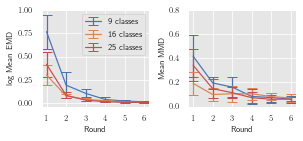

In [97]:
f = plot_emd_suppl()

In [98]:
f.savefig('ma2_suppl_bins__4.25x2_fontscale08.pdf', dpi=350, bbox_inches = 'tight',
    pad_inches = 0)

### Experiment threshold

In [88]:
#thresh = exp
bcnn_id = 'test_09'

bcnn_post_01 = np.load(f'{bcnn_id}/bcnn_{bcnn_id}_post.npy') #num_bins= 4^2
bcnn_post_01 = bcnn_post_01.astype('float64')

#thresh = 0.05
bcnn_id = 'test_02'

bcnn_post_02 = np.load(f'{bcnn_id}/bcnn_{bcnn_id}_post.npy') #num_bins= 4^2
bcnn_post_02 = bcnn_post_02.astype('float64')

#thresh = None
bcnn_id = 'test_10'

bcnn_post_03 = np.load(f'{bcnn_id}/bcnn_{bcnn_id}_post.npy') #num_bins= 4^2
bcnn_post_03 = bcnn_post_03.astype('float64')

In [89]:
bcnn_emd_01 = get_EMD(bcnn_post_01, exact_samples)
bcnn_emd_02 = get_EMD(bcnn_post_02, exact_samples)
bcnn_emd_03 = get_EMD(bcnn_post_03, exact_samples)

bcnn_mmd_01 = get_MMD(bcnn_post_01, exact_samples)
bcnn_mmd_02 = get_MMD(bcnn_post_02, exact_samples)
bcnn_mmd_03 = get_MMD(bcnn_post_03, exact_samples)

/home/psingh/.local/lib/python3.7/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


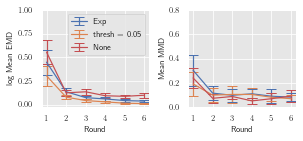

In [92]:
f = plot_emd_suppl(labels=['Exp', 'thresh = 0.05', 'None'])

In [93]:
f.savefig('ma2_suppl_thresh__4.25x2_fontscale08.pdf', dpi=350, bbox_inches = 'tight',
    pad_inches = 0)

### Different NDE in SNPE-C

In [36]:
#MAF
sbi_id = 'test_01'

sbi_post_01 = np.load(f'{sbi_id}/sbi_{sbi_id}_post.npy') #num_bins= 4^2
sbi_post_01 = sbi_post_01.astype('float64')

#MDN
sbi_id = 'test_05'

sbi_post_03 = np.load(f'{sbi_id}/sbi_{sbi_id}_post.npy') #num_bins= 4^2
sbi_post_03 = sbi_post_03.astype('float64')

#NSF
sbi_id = 'test_11'

sbi_post_04 = np.load(f'{sbi_id}/sbi_{sbi_id}_post.npy') #num_bins= 4^2
sbi_post_04 = sbi_post_03.astype('float64')

In [37]:
sbi_emd_01 = get_EMD(sbi_post_01, exact_samples)
sbi_emd_02 = get_EMD(sbi_post_02, exact_samples)
sbi_emd_03 = get_EMD(sbi_post_03, exact_samples)
#sbi_emd_04 = get_EMD(sbi_post_04, exact_samples)
sbi_emd_04 = sbi_emd

sbi_mmd_01 = get_MMD(sbi_post_01, exact_samples)
sbi_mmd_02 = get_MMD(sbi_post_02, exact_samples)
sbi_mmd_03 = get_MMD(sbi_post_03, exact_samples)
#sbi_mmd_04 = get_MMD(sbi_post_04, exact_samples)
sbi_mmd_04 = sbi_mmd

/home/psingh/.local/lib/python3.7/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [79]:
def plot_emd_suppl(labels=['MAF','MDN', 'NSF']):
    f = plt.figure(figsize=(4.25, 2))
    gs = f.add_gridspec(1, 2)
    
    def add_plot(data, ax, label, color):
        ax.errorbar(x=np.arange(6)+1, y=data.mean(axis=0), 
                yerr=data.std(axis=0), 
                capsize=5, color=color, label=label)
        return ax
    
    ax = f.add_subplot(gs[0,0])
    ax = add_plot(sbi_emd_01, ax, labels[0], 'C0')
    ax = add_plot(sbi_emd_03, ax, labels[1], 'C1')
    ax = add_plot(sbi_emd_04, ax, labels[2], 'C2')
    ax.errorbar(x=np.arange(6)+1, y=bcnn_emd.mean(axis=0)[1:], 
                yerr=bcnn_emd.std(axis=0)[1:], 
                capsize=5, color='C3', label='BCNN')
    
    ax.set_ylabel('log Mean EMD')
    
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_ylim([0.0, 2.0])
    
    ax.set_xlabel('Round')
    
    plt.tick_params(labelsize=8)
    plt.legend(fontsize=8)
    plt.xticks([1,2,3,4,5,6])
    
    
    
    
    ax = f.add_subplot(gs[0,1])
    ax = add_plot(sbi_mmd_01, ax, labels[0], 'C0')
    ax = add_plot(sbi_mmd_03, ax, labels[1], 'C1')
    ax = add_plot(sbi_mmd_04, ax, labels[2], 'C2')
    ax.errorbar(x=np.arange(6)+1, y=bcnn_mmd.mean(axis=0)[1:], 
                yerr=bcnn_mmd.std(axis=0)[1:], 
                capsize=5, color='C3', label='BCNN')
    
    ax.set_ylabel('Mean MMD')
    ax.set_yticks([0.0,0.25,0.5,0.75,1.0, 1.25])
    ax.set_xticks([1,2,3,4,5,6])
    ax.set_xlabel('Round')
    
    ax.set_ylim([0.0, 1.25])
    
    plt.tick_params(labelsize=8)
    #plt.legend(fontsize=8)
    plt.tight_layout()
    return f

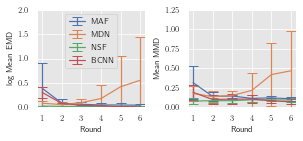

In [80]:
f = plot_emd_suppl()

In [81]:
f.savefig('ma2_suppl_NDE__4.25x2_fontscale08.pdf', dpi=350, bbox_inches = 'tight',
    pad_inches = 0)